# Machine Learning Foundation

## Course 5, Part d: Keras Intro LAB

## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Setup
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
## Import Keras objects for Deep Learning 
from tensorflow.keras.models  import Sequential # Sequential approach
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization # Model Elements
from tensorflow.keras.optimizers import Adam, SGD, RMSprop # Optimizers

In [3]:
## Load in the data set 
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"] # Changing the name of columns
diabetes_df = pd.read_csv('/users/salahkaf/desktop/diabetes.csv', names=names, header=0)

In [4]:
diabetes_df

,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
126,3,120,70,30,135,42.9,0.452,30,0
387,8,105,100,36,0,43.3,0.239,45,1
699,4,118,70,0,0,44.5,0.904,26,0
230,4,142,86,0,0,44.0,0.645,22,1
717,10,94,72,18,0,23.1,0.595,56,0


In [6]:
X = diabetes_df.iloc[:, :-1].values # NumPy Array
y = diabetes_df["has_diabetes"].values # NumPy Array
# X = diabetes_df.iloc[:, :-1] # Pandas df
# y = diabetes_df["has_diabetes"] # Pandas series

In [7]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [8]:
type(y_test)

numpy.ndarray

In [9]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise 1: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [10]:
### BEGIN SOLUTION
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [11]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.750
roc-auc is 0.831


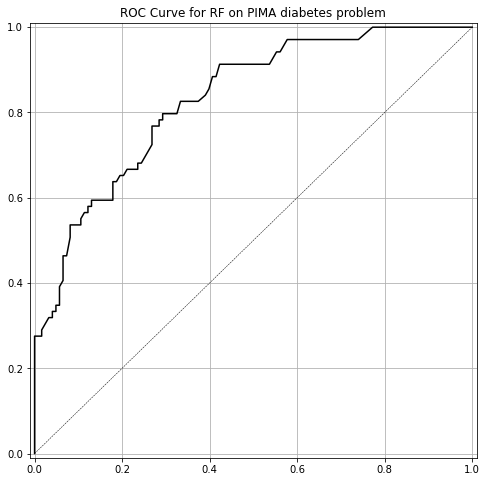

In [12]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred) 
    # fpr = [1 - Specificity] i.e., false positive rate or [1 - True Negative Rate]
    # tpr = true positive rate [sensitivity]
    #thr= threshold
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-') # plotting the receiver operating characteristic 
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [13]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [14]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential() # Initating the model
model_1.add(Dense(12, input_shape = (8,), activation = 'sigmoid')) # added the first hidden layer [(8,)
                                                                    #as we do not need to specify number of rows]
model_1.add(Dense(1,activation='sigmoid')) # output layer

2022-07-28 00:12:32.194517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()
# 108 because (8+1) * 12 = 108 [8 inputs and 1 bias term]
# 13 because 12 weight and 1 bias term

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?

Let's fit our model for 200 epochs.

In [16]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"]) # Optimizer, loss function, and metric
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200, verbose = 0)
# We used vebose = 0 to mute epochs print.
# We added the validation set as well to see how the model perform with each epoch.

# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

In [17]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

# y_pred_class_nn_1 = model_1.predict_classes(X_test_norm) # Hard predict
# The function above was removed in TensorFlow version 2.6. According to the keras in rstudio reference.
# Use this code instead: 
y_pred_class_nn_1 = (model_1.predict(X_test_norm) >= 0.5).astype(int) #.ravel() no need for ravel

y_pred_prob_nn_1 = model_1.predict(X_test_norm) # probabilitistic predict

6/6 [==============================] - 0s 1ms/step


In [18]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [19]:
y_pred_prob_nn_1[:10]

array([[0.41676465],
       [0.49571294],
       [0.36056975],
       [0.27171007],
       [0.32388267],
       [0.45234844],
       [0.2628786 ],
       [0.3366568 ],
       [0.4863204 ],
       [0.29917336]], dtype=float32)

accuracy is 0.661
roc-auc is 0.755


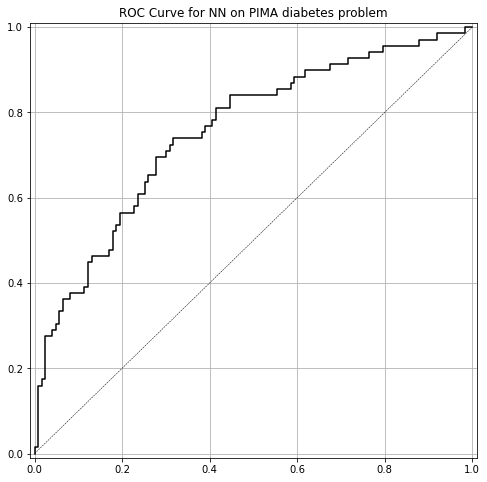

In [20]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [21]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

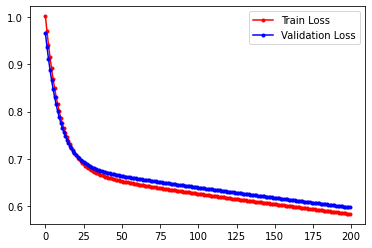

In [22]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

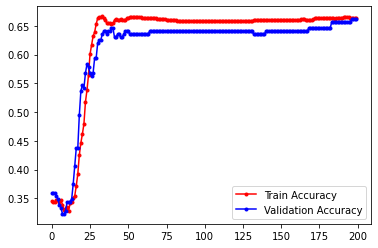

In [23]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["accuracy"],'r', marker='.', label="Train Accuracy")
ax.plot(run_hist_1.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ax.legend()

In [24]:
# The decreament in both validation set and train set indicates that the model might benift from further training.

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [25]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000,verbose = 0)

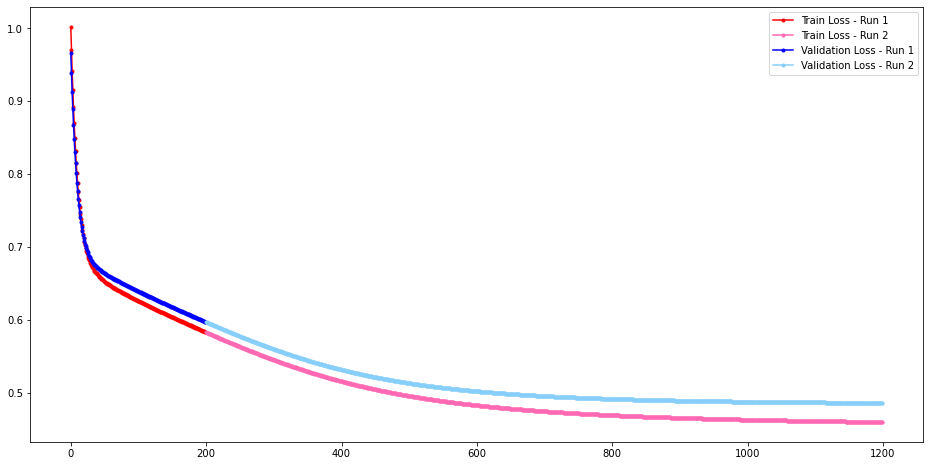

In [26]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

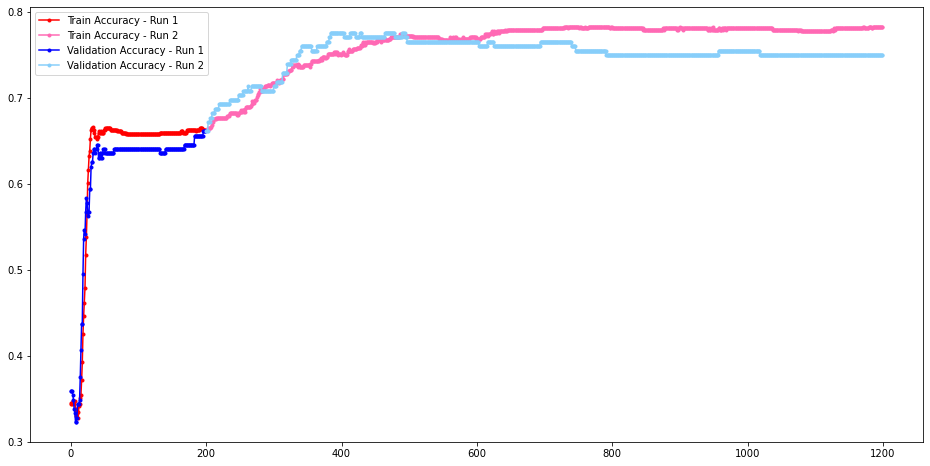

In [27]:
n = len(run_hist_1.history["accuracy"])
m = len(run_hist_1b.history['accuracy'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["accuracy"],'r', marker='.', label="Train Accuracy - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["accuracy"], 'hotpink', marker='.', label="Train Accuracy - Run 2")

ax.plot(range(n), run_hist_1.history["val_accuracy"],'b', marker='.', label="Validation Accuracy - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_accuracy"], 'LightSkyBlue', marker='.',  label="Validation Accuracy - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise 2
For this exercise, do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [28]:
### BEGIN SOLUTION
model_2 = Sequential()
model_2.add(Dense(6, input_shape=(8,), activation="relu"))
model_2.add(Dense(6,  activation="relu")) # probably is best practice than sigmoid
model_2.add(Dense(1, activation="sigmoid")) # To have an output between 0 and 1

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500, verbose = 0)

In [29]:
run_hist_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

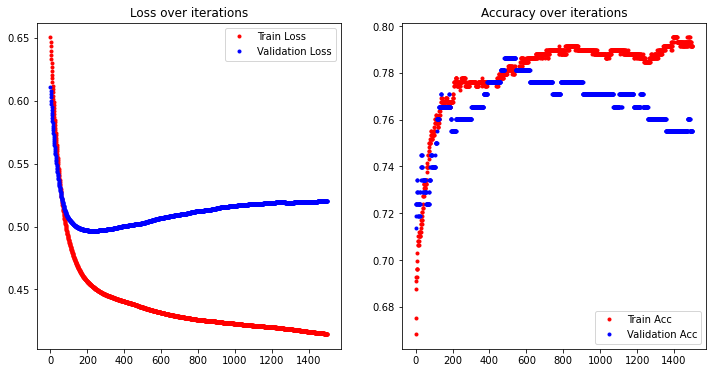

In [30]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6)) # Initate figure without bounding box yet
ax = fig.add_subplot(1, 2, 1) # add bounding box one
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2) # add bounding box two
ax.plot(range(n), (run_hist_2.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

6/6 [==============================] - 0s 1ms/step

accuracy is 0.755
roc-auc is 0.813


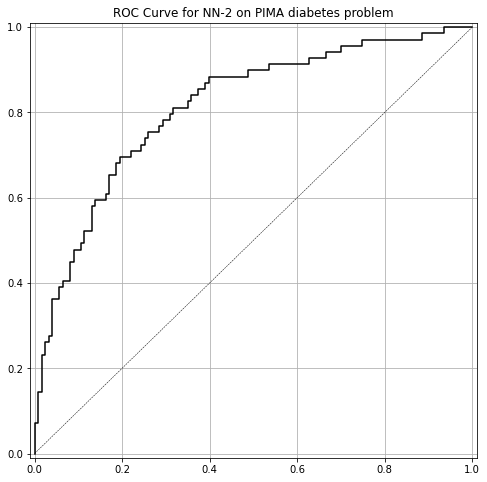

In [31]:
y_pred_class_nn_2 = (model_2.predict(X_test_norm) >= 0.5).astype(int)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')
### END SOLUTION

In [32]:
### Trying different parameters as follows:

model_3 = Sequential()
# Create 2 hidden layers
model_3.add(Dense(4, input_shape=(8,), activation="relu"))
model_3.add(Dense(4,  activation="relu")) 
model_3.add(Dense(1, activation="sigmoid")) # To have an output between 0 and 1

model_3.compile(SGD(lr = .004), "binary_crossentropy", metrics=["accuracy"])
run_hist_3 = model_3.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=500, verbose = 0)

Text(0.5, 1.0, 'Accuracy over iterations')

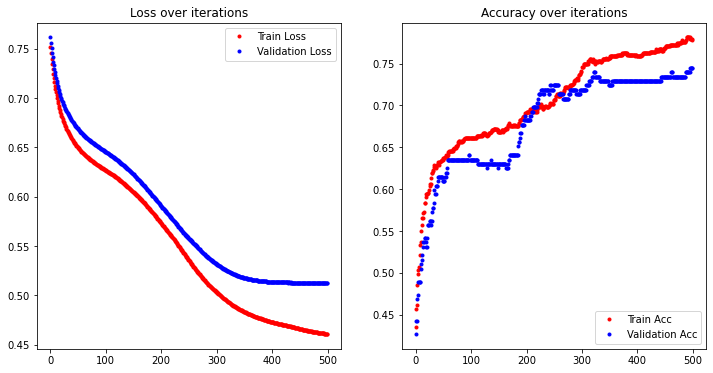

In [33]:
n = len(run_hist_3.history["loss"])

fig = plt.figure(figsize=(12, 6)) # Initiate the figure 
ax = fig.add_subplot(1, 2, 1) # bounding box 1 
ax.plot(range(n), (run_hist_3.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_3.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)  # bounding box 2
ax.plot(range(n), (run_hist_3.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_3.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

6/6 [==============================] - 0s 1ms/step

accuracy is 0.745
roc-auc is 0.794


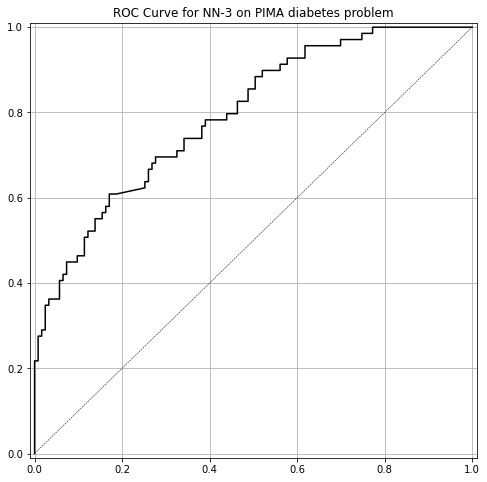

In [34]:
y_pred_class_nn_3 = (model_3.predict(X_test_norm) >= 0.5).astype(int)
y_pred_prob_nn_3 = model_3.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_3)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_3)))

plot_roc(y_test, y_pred_prob_nn_3, 'NN-3')
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation